In [24]:
# 사진 갯수
from glob import glob
pngs = sorted(glob('unzip/*/*/*/*/*.png')) 
len(pngs)

473351

In [25]:
# 파일명 파싱
from tqdm.auto import tqdm
print(pngs[-1])
%time names = [e.split('/')[-1].split('.')[0].split('_') for e in pngs]
J = lambda n, i: '_'.join(n[:i])
A = lambda n: [J(n,1), J(n,2), J(n,3) , J(n,4), J(n,5)]
%time rows = [A(n) + [p] for n, p in zip(names, pngs)]
rows[-2:]

unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20397.png
CPU times: user 1 s, sys: 184 ms, total: 1.19 s
Wall time: 1.18 s
CPU times: user 1.09 s, sys: 31.8 ms, total: 1.12 s
Wall time: 1.12 s


[['OUT',
  'OUT_H00646',
  'OUT_H00646_SN4',
  'OUT_H00646_SN4_100810',
  'OUT_H00646_SN4_100810_20394',
  'unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20394.png'],
 ['OUT',
  'OUT_H00646',
  'OUT_H00646_SN4',
  'OUT_H00646_SN4_100810',
  'OUT_H00646_SN4_100810_20397',
  'unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100810_20397.png']]

In [26]:
# 데이터 프레임으로 변환
import pandas as pd
df = pd.DataFrame(rows, columns=['Location', 'Human', 'Case', 'Camera', 'PNG', 'path'])
df.tail(5)

,Location,Human,Case,Camera,PNG,path
473346,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20385,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473347,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20388,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473348,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20391,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473349,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20394,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...
473350,OUT,OUT_H00646,OUT_H00646_SN4,OUT_H00646_SN4_100810,OUT_H00646_SN4_100810_20397,unzip/OUT/H00646/SN4/100810/OUT_H00646_SN4_100...


In [27]:
# 컬럼별  nuique 통계
df.describe().loc[['unique']]

,Location,Human,Case,Camera,PNG,path
unique,2,102,401,3981,473351,473351


In [28]:
# H(uman) 샘플 보기
import ipyplot
h = df['Human'].sample(n=1).values[0]
print(h)
sample_h = df.query('Human == @h').sample(n=10)['path'].values
ipyplot.plot_images(sample_h, img_width=30, force_b64=True)

OUT_H00511


['OUT_H00511_SN2' 'OUT_H00511_SN1']



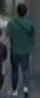
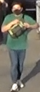
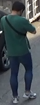
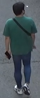
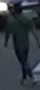
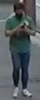
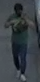
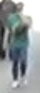
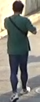
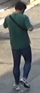


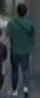
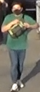
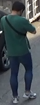
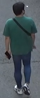
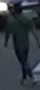
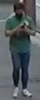
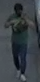
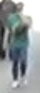
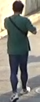
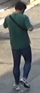


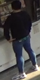
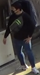
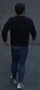
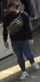
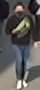
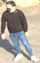
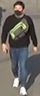
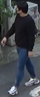
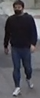
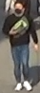


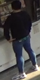
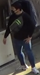
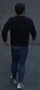
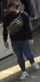
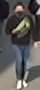
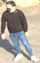
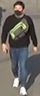
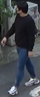
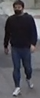
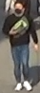

In [34]:
# Case 샘플 보기
case = df.query('Human == @h')['Case'].sample(n=2).values[:2]
print(case)
sample_case = df.query('Case == @case[0]').sample(10)['path'].values
ipyplot.plot_images(sample_case, img_width=40, force_b64=True)

sample_case = df.query('Case == @case[1]').sample(10)['path'].values
ipyplot.plot_images(sample_case, img_width=40, force_b64=True)

In [35]:
# Camera 별 샘플 보기
camera = df.query('Human == @h and Case == @case[0]')['Camera'].sample(n=2).values[:2]
print(camera)
sample_camera_0 = df.query('Camera== @camera[0]')['path'].sample(n=40).values[::4]
ipyplot.plot_images(sample_camera_0, img_width=30, force_b64=True)

sample_camera_1 = df.query('Camera == @camera[1]')['path'].sample(n=40).values[::4]
ipyplot.plot_images(sample_camera_1, img_width=30, force_b64=True)

['OUT_H00511_SN2_092809' 'OUT_H00511_SN2_092809']


In [12]:
from torchreid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_ain_x1_0',
    model_path='./weights/osnet_ain_x1_0_reid.pth',
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/kts2/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./weights/osnet_ain_x1_0_reid.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [13]:
ebds_0 = extractor(list(sample_camera_0))
ebds_1 = extractor(list(sample_camera_1))
ebds_0.shape, ebds_1.shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [14]:
import random
import torch
import torch.nn.functional as F


# 사잇각의 평균, 표준편차, 최대, 최소
def mean_diff(ebds):
    ebds = F.normalize(ebds, p=2, dim=-1)
    ebds_t = ebds.transpose(1, 0)
    dots = ebds@ebds_t
    diff = 1 - dots
    mean = diff.sum()/(len(ebds)*len(ebds) - len(ebds))
    r = [mean, diff.max(), diff.std(), diff.clone().fill_diagonal_(1).min()]
    r = [e.cpu().numpy().round(3) for e in r]
    return r

In [15]:
# 동일인 사잇각 평균, max, std, min
sts_0 = mean_diff(ebds_0)
sts_1 = mean_diff(ebds_1)
sts   = mean_diff(torch.cat([ebds_0, ebds_1], dim=0))
pd.DataFrame([sts_0, sts_1, sts], 
             index=['id_0', 'id_1', 'id_merge'], 
             columns=['mean', 'max', 'std', 'min'])

,mean,max,std,min
id_0,0.136,0.209,0.053,0.014
id_1,0.188,0.283,0.087,0.039
id_merge,0.261,0.444,0.120,0.014


In [16]:
# 다른 사람 샘플 10개 고르기
hs = df['Human'].sample(n=10).unique()[:3]
print(hs)
sample_h_0 = df.query('Human ==  @hs[0]').sample(n=10)['path'].values.tolist()
sample_h_1 = df.query('Human ==  @hs[1]').sample(n=10)['path'].values.tolist()
sample_h_2 = df.query('Human ==  @hs[1]').sample(n=10)['path'].values.tolist()

['OUT_H00549' 'IN_H00291' 'IN_H00278']


In [17]:
# 임베딩 구하기
ebds_0 = extractor(list(sample_h_0))
ebds_1 = extractor(list(sample_h_1))
ebds_2 = extractor(list(sample_h_2))
ebds_0.shape, ebds_1.shape, ebds_2.shape

(torch.Size([10, 512]), torch.Size([10, 512]), torch.Size([10, 512]))

In [18]:
# 다른 사람간의 사잇각 평균, max, std, min
sts_0 = mean_diff(ebds_0)
sts_1 = mean_diff(ebds_1)
sts_2 = mean_diff(ebds_2)
sts   = mean_diff(torch.cat([ebds_0, ebds_1, ebds_2], dim=0))
pd.DataFrame([sts_0, sts_1, sts_2, sts], 
             index=['h_0', 'h_1', 'h_2', 'h_merge'], 
             columns=['mean', 'max', 'std', 'min'])

,mean,max,std,min
h_0,0.279,0.438,0.124,0.062
h_1,0.451,0.715,0.206,0.145
h_2,0.447,0.691,0.225,0.090
h_merge,0.487,0.715,0.172,0.062


In [19]:
# 모든 사람에 대해 embeding 값 구하기
hs = df['Human'].unique()
hs = [df.query('Human == @e').sample(n=100)['path'].tolist() for e in hs]
ebds = [extractor(e) for e in tqdm(hs)]

In [20]:
# 모든 사람에 대한 통계값 구하기
stat = [mean_diff(e) for e in ebds]
stat

[[0.373, 0.683, 0.139, 0.008],
 [0.356, 0.62, 0.107, 0.006],
 [0.341, 0.701, 0.116, 0.014],
 [0.412, 0.675, 0.13, 0.022],
 [0.456, 0.717, 0.157, 0.017],
 [0.42, 0.723, 0.233, 0.008],
 [0.386, 0.679, 0.143, 0.022],
 [0.403, 0.693, 0.134, 0.014],
 [0.453, 0.695, 0.134, 0.035],
 [0.367, 0.635, 0.115, 0.012],
 [0.455, 0.706, 0.119, 0.018],
 [0.276, 0.627, 0.097, 0.028],
 [0.427, 0.696, 0.126, 0.027],
 [0.41, 0.667, 0.131, 0.012],
 [0.423, 0.702, 0.128, 0.037],
 [0.43, 0.755, 0.165, 0.022],
 [0.472, 0.759, 0.196, 0.012],
 [0.317, 0.68, 0.102, 0.017],
 [0.395, 0.703, 0.154, 0.014],
 [0.409, 0.713, 0.139, 0.013],
 [0.444, 0.711, 0.143, 0.02],
 [0.458, 0.708, 0.15, 0.025],
 [0.402, 0.69, 0.12, 0.017],
 [0.348, 0.672, 0.103, 0.021],
 [0.345, 0.64, 0.115, 0.014],
 [0.35, 0.584, 0.112, 0.003],
 [0.302, 0.65, 0.101, 0.018],
 [0.417, 0.646, 0.121, 0.01],
 [0.332, 0.688, 0.133, 0.019],
 [0.346, 0.688, 0.11, 0.016],
 [0.361, 0.749, 0.136, 0.021],
 [0.401, 0.664, 0.137, 0.025],
 [0.412, 0.656, 0.133, 

In [21]:
df = pd.DataFrame(stat, index= [f'human_{e:03d}' for e in range(102)],
             columns=['mean', 'max', 'std', 'min'])
df

,mean,max,std,min
human_000,0.373,0.683,0.139,0.008
human_001,0.356,0.620,0.107,0.006
human_002,0.341,0.701,0.116,0.014
human_003,0.412,0.675,0.130,0.022
human_004,0.456,0.717,0.157,0.017
...,...,...,...,...
human_097,0.371,0.691,0.144,0.011
human_098,0.326,0.596,0.090,0.026
human_099,0.385,0.682,0.139,0.028
human_100,0.311,0.602,0.103,0.032


In [22]:
df.describe()

,mean,max,std,min
count,102.000000,102.000000,102.000000,102.000000
mean,0.375275,0.662098,0.127882,0.021422
std,0.053372,0.054118,0.026059,0.009110
min,0.266000,0.534000,0.081000,0.003000
25%,0.338250,0.623250,0.109000,0.015250
50%,0.373000,0.673500,0.130000,0.020500
75%,0.411750,0.702750,0.143750,0.026750
max,0.484000,0.764000,0.233000,0.055000
